In [1]:
# Install required packages.
!pip install -q torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install -q torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Amazon
from torch_geometric.transforms import NormalizeFeatures


In [2]:
def visualize(out, color):
    """
    Produces TSNE visualization for an embedding
    :param out: embedding - output of model
    :param color: label to be used for colors
    """
    z = TSNE(n_components=2, random_state=13).fit_transform(out.detach().cpu().numpy())
    color = color.detach().cpu().numpy()
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()


def visualize_training(data, z, num_rows, vis_epochs):
    """
    Produces a grid of tsne plots for each epoch in vis_epochs
    :param data: original data model was trained on
    :param z: list of model outputs at each epoch to be visualized
    :param num_rows: number if rows of plots
    :param vis_epochs: list of epochs to be visualized - must be same size as z
    """
    fig, axs = plt.subplots(num_rows, int(len(z) / num_rows),
                            figsize=(10 * (len(z) / num_rows), 10 * num_rows),
                            sharex='all', sharey='all')
    plt.xticks([])
    plt.yticks([])
    color = data.y.detach().cpu().numpy()
    for i, ax in enumerate(fig.axes):
        ax.scatter(z[i][:, 0], z[i][:, 1], s=70, c=color, cmap="Set2")
        ax.set_title('Epoch {}'.format(vis_epochs[i]), fontsize=40)
    plt.show()


def plot_train_test_acc(train_acc, test_acc):
    """
    Plots train and test accuracy through training
    :param train_acc: list of train accuracies for each epoch
    :param test_acc: list of test accuracies for each epoch
    """
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc, label="Test Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('GCN Model Accuracy')
    plt.legend()
    plt.show()


In [3]:
class GCN(torch.nn.Module):
    """
    3-Layer graph convolutional network
        """
    def __init__(self, dataset, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(13)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x


class MLP(torch.nn.Module):
    """
    3-Layer fully-connected linear neural network
        """
    def __init__(self, dataset, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(13)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        return x

In [4]:
def train(model, optimizer, criterion, data):
    model.train()
    optimizer.zero_grad()
    if isinstance(model, GCN):
        out = model(data.x, data.edge_index)
    else:
        out = model(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(model, data):
    model.eval()
    if isinstance(model, GCN):
        out = model(data.x, data.edge_index)
    else:
        out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    accs = []  # track accuracy for train, validation, and test
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


def run_training(model, data, vis_epochs, num_epochs=1000, verbose=False):
    """
    Trains model on input data and tracks accuracy.
    :param num_epochs: number of epochs to train
    :param model: model to be trained
    :param data: full data (train, val, and test)
    :param vis_epochs: epochs to be saved for visualization
    :param verbose: if True prints current epoch and accuracy
    :return: final test accuracy, tsne visualization samples, full train accuracy, full test accuracy
    """
    tsne_vis_samples = []  # store samples for tsne visualization
    train_acc_values = []  # train accuracies during training
    test_acc_values = []  # test accuracies during training
    best_val_acc = test_acc = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    if 0 in vis_epochs:
        model.eval()
        if isinstance(model, GCN):
            tsne_vis_samples.append(model(data.x, data.edge_index))
        else:
            tsne_vis_samples.append(model(data.x))

    for epoch in range(1, num_epochs + 1):
        loss = train(model, optimizer, criterion, data)
        train_acc, val_acc, tmp_test_acc = test(model, data)
        if epoch in vis_epochs:
            model.eval()
            if isinstance(model, GCN):
                tsne_vis_samples.append(model(data.x, data.edge_index))
            else:
                tsne_vis_samples.append(model(data.x))
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        train_acc_values.append(train_acc)
        test_acc_values.append(tmp_test_acc)
        if verbose:
            print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} Train: {train_acc:.4f}, '
                  f'Val: {val_acc:.4f}, Test: {tmp_test_acc:.4f}, '
                  f'Final Test: {test_acc:.4f}')
    return test_acc, tsne_vis_samples, train_acc_values, test_acc_values


In [5]:
def run(model, dataset, vis_epochs, shuffle=False, num_epochs=1000, model_runs=1, train_percent=0.05, val_percent=0.15):
    data = dataset[0]

    if shuffle:
        tmp = data.edge_index.numpy()
        rng = np.random.default_rng()
        rng.shuffle(tmp[0])
        data.edge_index = torch.from_numpy(tmp)

    train_stats = []
    for i in range(model_runs):
        # Separate Train, Validation, Test groups
        test_percent = 1 - train_percent - val_percent

        groups = np.random.choice([0, 1, 2], p=[train_percent, val_percent, test_percent], size=data.y.shape[0])
        tr, va, te = (groups[..., None] == np.arange(3)[None, :]).T

        data.train_mask = torch.from_numpy(tr)
        data.test_mask = torch.from_numpy(te)
        data.val_mask = torch.from_numpy(va)

        # Set up model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        data = data.to(device)

        # Run Trianing
        test_acc, tsne_vis_samples, train_acc_values, test_acc_values = \
            run_training(model, data, vis_epochs, num_epochs=num_epochs, verbose=False)
        train_stats.append(test_acc)

    var = np.var(train_stats)
    mean = np.mean(train_stats)
    if model_runs > 1:
        print(f'Average Test Accuracy: {mean:.4f}, Variance: {var:.4f}')
    print(f'Final Test Accuracy: {test_acc:.4f}')
    plot_train_test_acc(train_acc_values, test_acc_values)

    # get training TSNE
    z = []
    if len(vis_epochs) <= 5:
        num_rows = 1
    else:
        num_rows = int(len(vis_epochs) / 5)
    for i in tsne_vis_samples:
        z.append(TSNE(n_components=2, random_state=13).fit_transform(i.detach().cpu().numpy()))
    visualize_training(data, z, num_rows, vis_epochs)
    


In [6]:
# Get Dataset
dataset = Amazon(root='data/Amazon', name='Photo', transform=NormalizeFeatures())
num_epochs = 1000
vis_epochs = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]


Final Test Accuracy: 0.6537


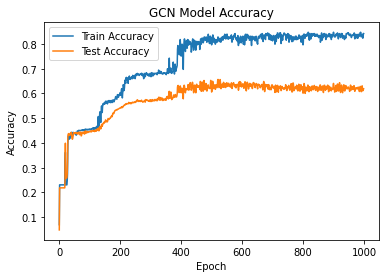

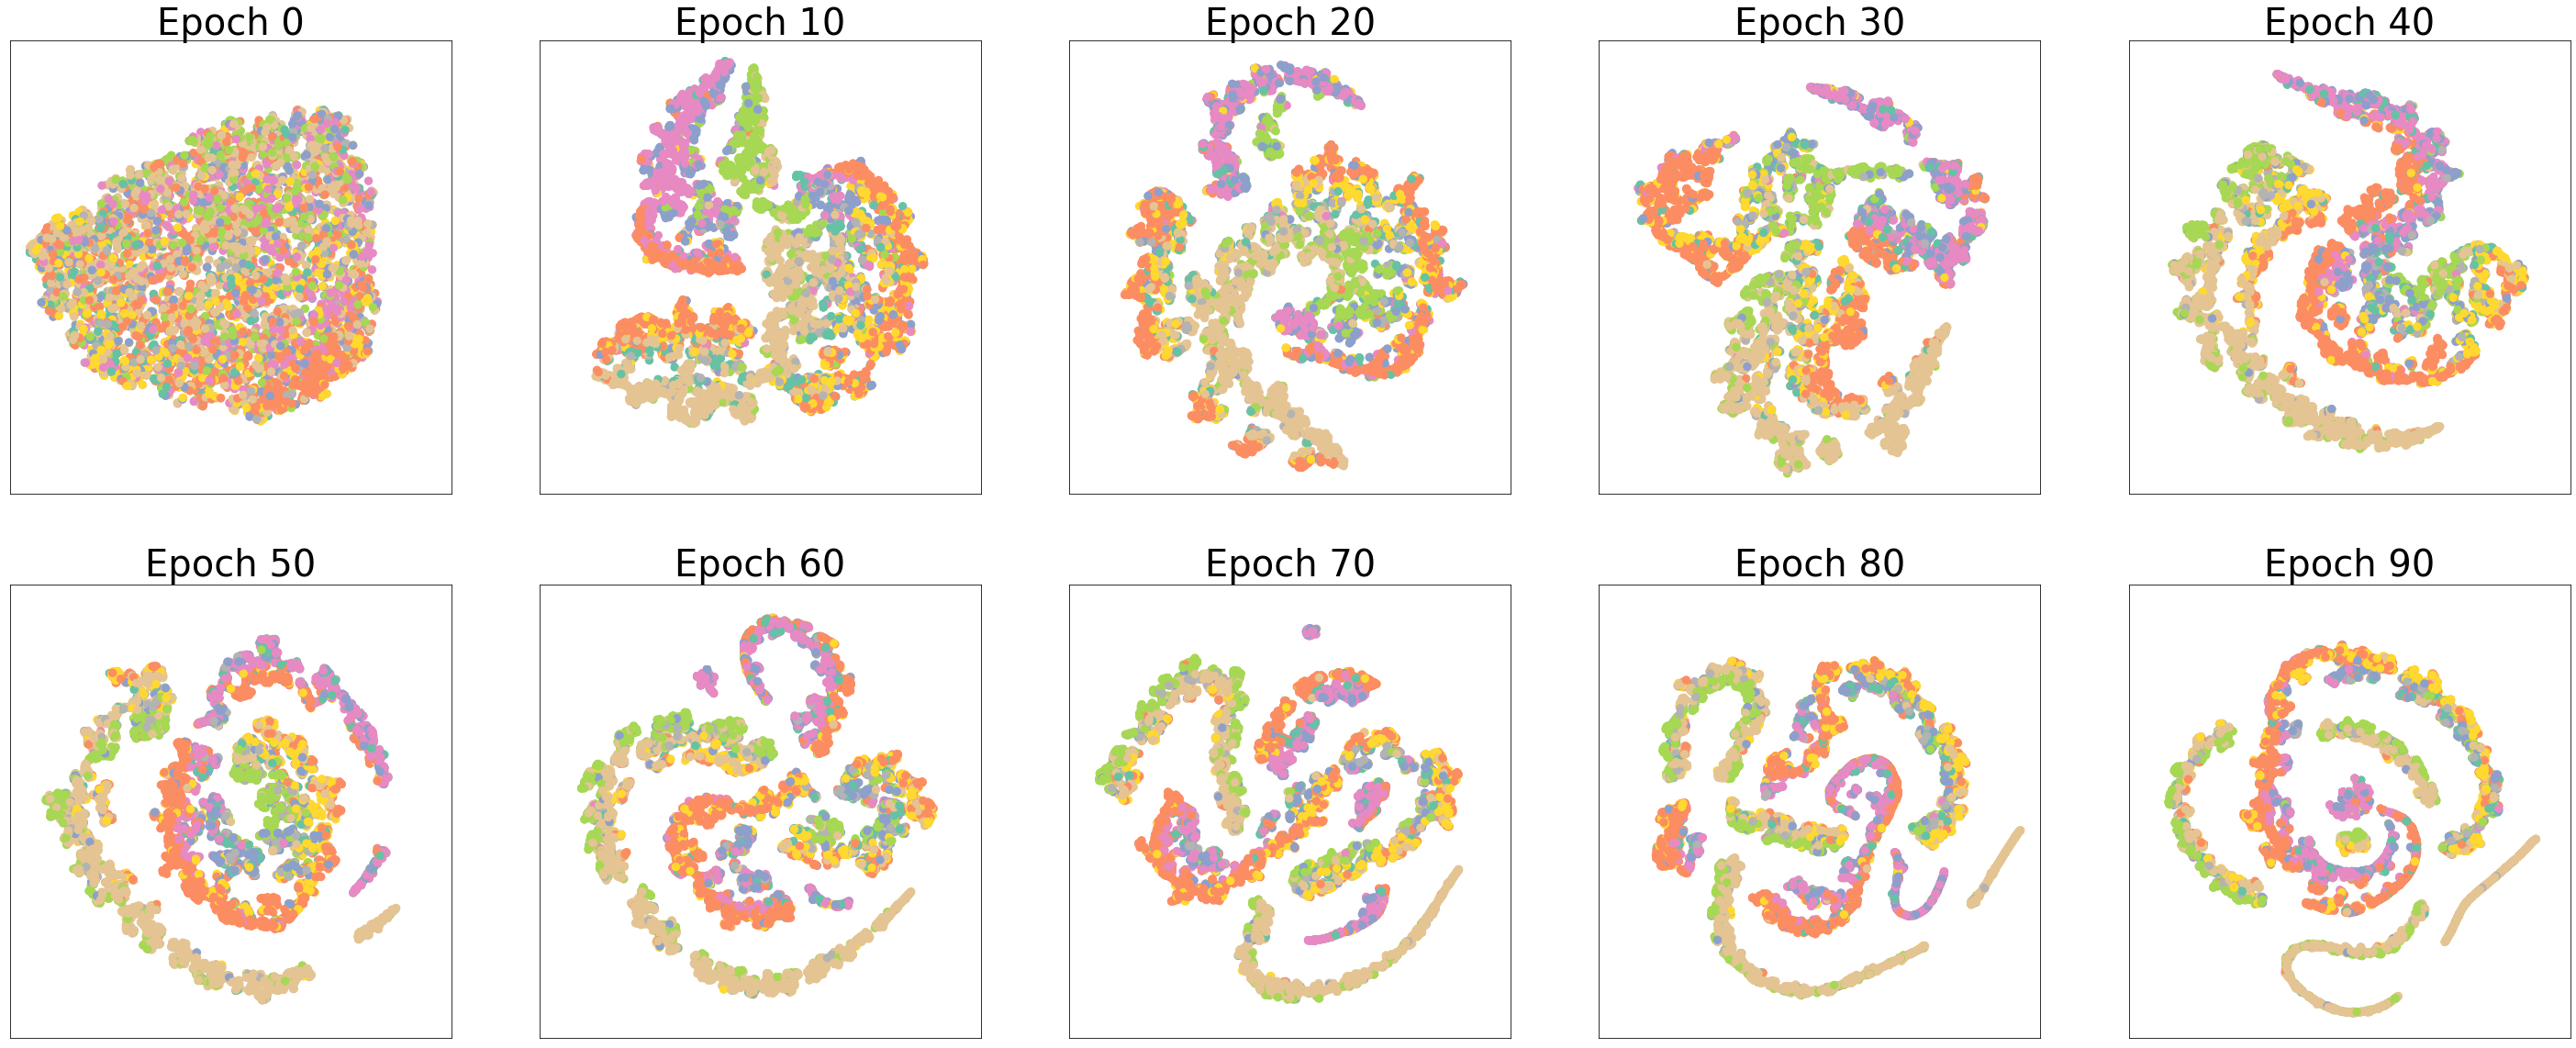

In [7]:
# Run MLP Model
model = MLP(dataset=dataset, hidden_channels=16)
run(model, dataset,vis_epochs, shuffle=False, num_epochs=num_epochs)

Final Test Accuracy: 0.8911


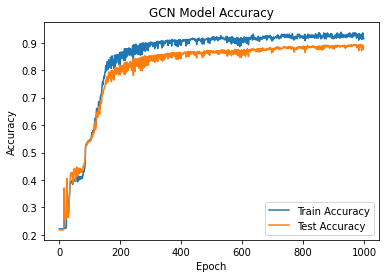

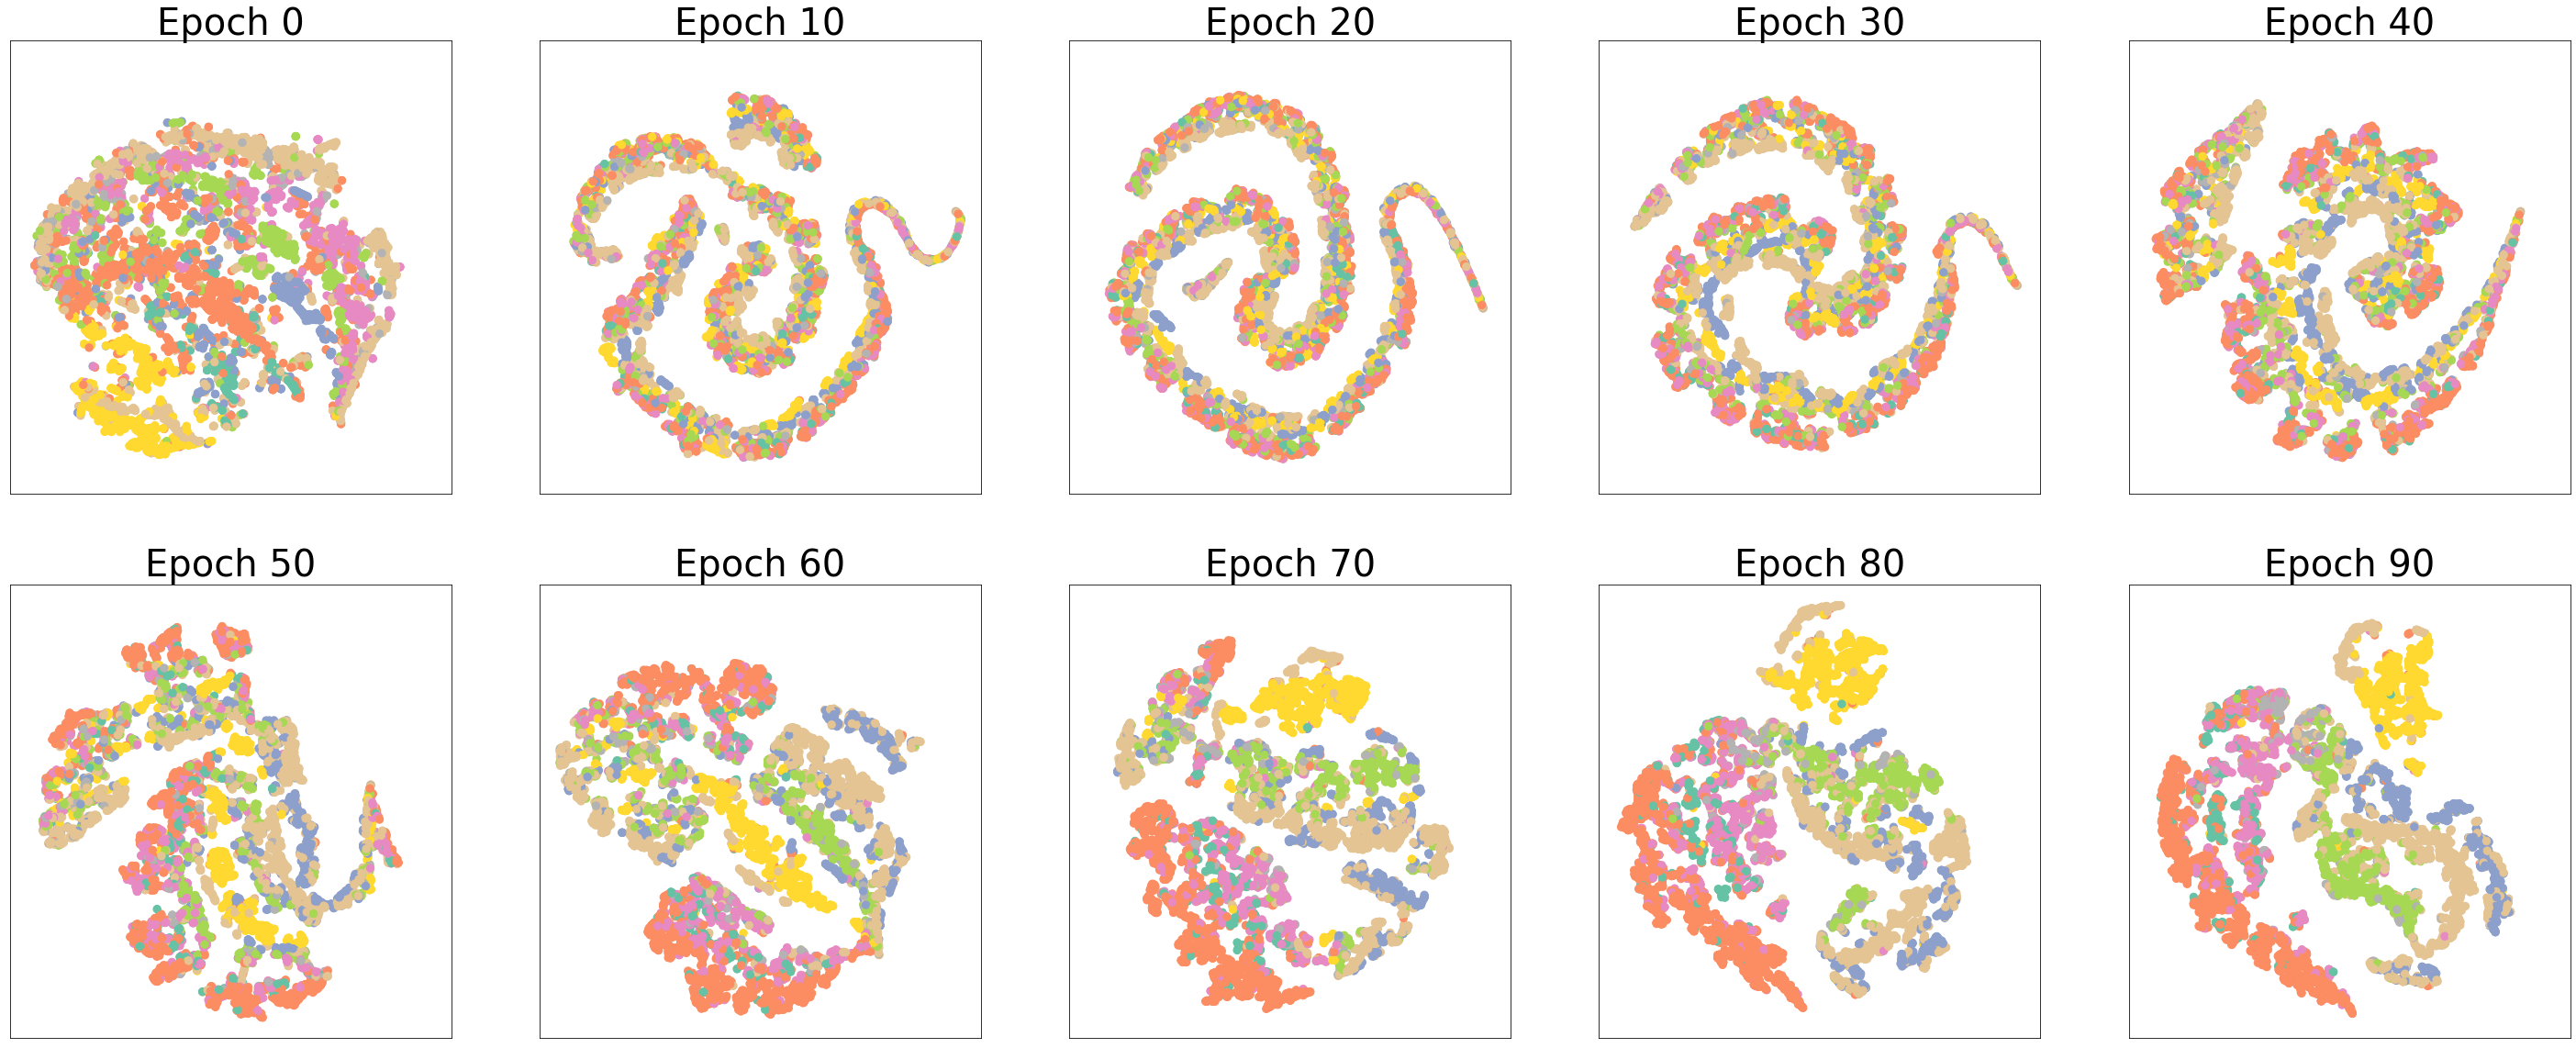

In [8]:
# Run GCN Model
model = GCN(dataset=dataset, hidden_channels=16)
run(model, dataset,vis_epochs, shuffle=False, num_epochs=num_epochs)


Final Test Accuracy: 0.2803


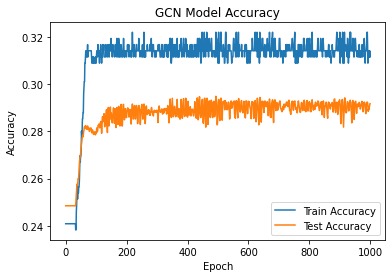

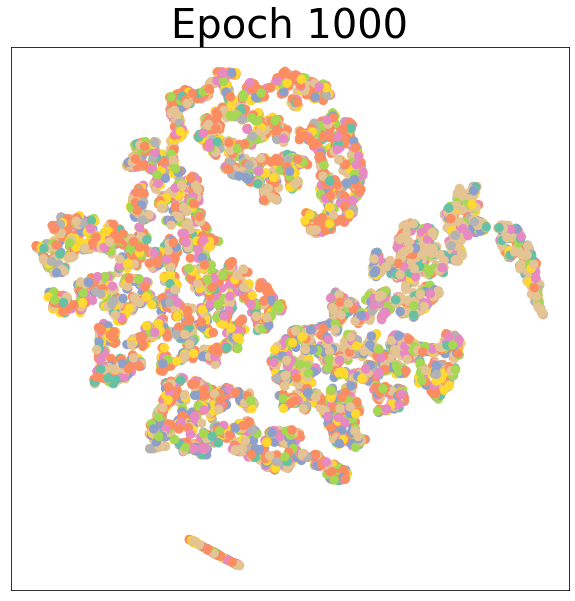

In [9]:
# Run GCN Model with Shuffled edges
vis_epochs = [1000]
model = GCN(dataset=dataset, hidden_channels=16)
run(model, dataset,vis_epochs, shuffle=True, num_epochs=num_epochs)
